In [ ]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from keras import regularizers
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split

In [3]:
# cap = cv2.VideoCapture(0)  # 0 for webcam

[ WARN:0] global /tmp/pip-req-build-jpmv6t9_/opencv/modules/videoio/src/cap_v4l.cpp (890) open VIDEOIO(V4L2:/dev/video0): can't open camera by index


In [4]:
# pip install opencv-python

Note: you may need to restart the kernel to use updated packages.


In [5]:
# pip install python

ERROR: Could not find a version that satisfies the requirement python (from versions: none)
ERROR: No matching distribution found for python
Note: you may need to restart the kernel to use updated packages.


In [6]:
IMAGE_SIZE = 256
BATCH_SIZE = 30
EPOCHS = 50
CHANNEL = 3

In [7]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    '/kaggle/input/drowsiness-dataset/train',
    shuffle = True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 2900 files belonging to 4 classes.


2023-01-15 09:42:52.644493: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-15 09:42:52.645467: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-15 09:42:52.831955: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-15 09:42:52.832979: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-15 09:42:52.833789: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

In [8]:
labels = dataset.class_names
labels

['Closed', 'Open', 'no_yawn', 'yawn']

In [9]:
# for image_batch, label_batch in dataset.take(1):
#     plt.imshow(image_batch[0].numpy().astype("uint8"))
#     plt.title(labels[label_batch[0]])

### Now we have to visualize all labels images

#### Closed Eyes

Closed


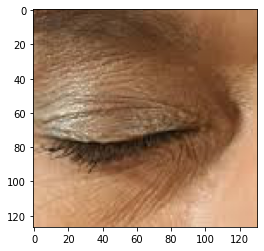

In [10]:
plt.imshow(plt.imread("../input/drowsiness-dataset/train/Closed/_10.jpg"))
print('Closed')

#### Open Eyes

Open


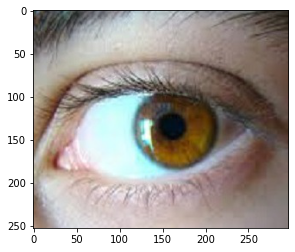

In [11]:
plt.imshow(plt.imread("../input/drowsiness-dataset/train/Open/_10.jpg"))
print('Open')

#### Yawn Face

yawn


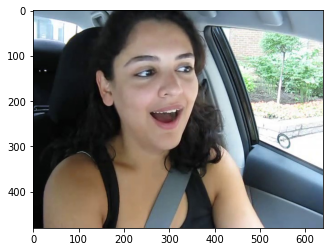

In [12]:
plt.imshow(plt.imread("../input/drowsiness-dataset/train/yawn/50.jpg"))
print('yawn')

#### No_Yawn Face

no_yawn


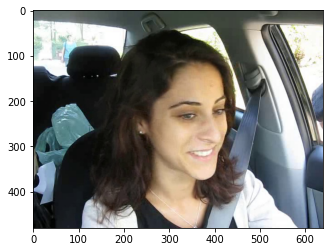

In [13]:
plt.imshow(plt.imread("../input/drowsiness-dataset/train/no_yawn/1139.jpg"))
print('no_yawn')

### Now, We have to make a function which select only face of 'yawn' & 'no_yawn' lable images

In [14]:
def face_for_yawn(direc_path1="../input/drowsiness-dataset/train",
                  face_path1="../input/prediction-images/haarcascade_frontalface_default.xml"):
    data1 = []
    labels1 = ["yawn", "no_yawn"]
    for label in labels1:
        final_path1 = os.path.join(direc_path1, label)
        class_num1 = labels1.index(label)
        print(class_num1)
#         print(f'{label} means: {class_num1}')
        for image in os.listdir(final_path1):
            image_array = cv2.imread(os.path.join(final_path1, image), cv2.IMREAD_COLOR)
            face_cascade = cv2.CascadeClassifier(face_path1)
            faces = face_cascade.detectMultiScale(image_array, 1.3, 5)
            for (x, y, width, height) in faces:
                img = cv2.rectangle(image_array, (x, y), (x+width, y+height), (0, 0, 255), 2)
                roi_color = img[y:y+height, x:x+width]
                resized_array = cv2.resize(roi_color, (IMAGE_SIZE, IMAGE_SIZE))
                data1.append([resized_array, class_num1])
    return data1


yawn_no_yawn = face_for_yawn()

0
1


### Now, We have to make a function for open and closed eyes

In [15]:
def open_closed_eye(direc_path2="../input/drowsiness-dataset/train/",
             face_path2="../input/prediction-images/haarcascade_frontalface_default.xml",
             eye_path="../input/prediction-images/haarcascade.xml"):
    labels2 = ['Closed', 'Open']
    data2 = []
    for label in labels2:
        final_path2 = os.path.join(direc_path2, label)
        class_num2 = labels2.index(label)
        class_num2 +=2
        print(class_num2)
#         print(f'{label} means: {class_num2}')
        for img in os.listdir(final_path2):
                img_array = cv2.imread(os.path.join(final_path2, img), cv2.IMREAD_COLOR)
                resized_array = cv2.resize(img_array, (IMAGE_SIZE, IMAGE_SIZE))
                data2.append([resized_array, class_num2])
    return data2

open_closed = open_closed_eye()

2
3


### Extending data

In [16]:
def extend_data():
    d1  =  face_for_yawn()
    d2  =  open_closed_eye()
    d1.extend(d2)
    return d1

In [17]:
data = extend_data()

0
1
2
3


In [18]:
len(data)

1925

In [19]:
import random
random.shuffle(data) # shuffling data for ignoring the biasness while training

In [20]:
x = list()
y = list()

for features, label in data:
    x.append(features)
    y.append(label)

### Converting x and y in array form

In [21]:
x = np.array(x)
y = np.array(y)

In [22]:
len(x)

1925

In [23]:
len(y)

1925

In [24]:
x.shape

(1925, 256, 256, 3)

In [25]:
y.shape

(1925,)

In [26]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.25, random_state = 0)

In [27]:
x_train.shape

(1443, 256, 256, 3)

In [28]:
x_test.shape

(482, 256, 256, 3)

### Perform Data Augmentation to make more data from existing data

In [29]:
train_generator = ImageDataGenerator(rescale=1/255, zoom_range=0.2, horizontal_flip=True, rotation_range=30)
test_generator = ImageDataGenerator(rescale=1/255)

train_generator = train_generator.flow(np.array(x_train), y_train, shuffle=False)
test_generator = test_generator.flow(np.array(x_test), y_test, shuffle=False)

In [30]:
  n_classes = 4

models = models.Sequential([
    
    layers.Conv2D(256, (3, 3), activation="relu", input_shape = x_train.shape[1:]),
    layers.MaxPooling2D(2, 2),
    
    layers.Conv2D(128, (3, 3), activation="relu"),
    layers.MaxPooling2D(2, 2),
    
    layers.Conv2D(64, (3, 3), activation="relu"),
    layers.MaxPooling2D(2, 2),
    
    layers.Conv2D(32, (3, 3), activation="relu"),
    layers.MaxPooling2D(2, 2),
    
    layers.Flatten(),
    layers.Dropout(0.5),
    
    layers.Dense(64, activation="relu"),
    layers.Dense(n_classes, activation="softmax")
])

In [31]:
models.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 254, 256)     7168      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 256)     0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 125, 128)     295040    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 64)        73792     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 32)        1

In [32]:
models.compile(
    optimizer = 'adam',
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy']
)

In [33]:
history = models.fit(
    train_generator,
    epochs = EPOCHS,
    verbose =1,
    shuffle = True,
    validation_data = test_generator
)

2023-01-15 09:47:59.566742: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50


2023-01-15 09:48:02.381406: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


46/46 [==============================] - 41s 556ms/step - loss: 1.0131 - accuracy: 0.5288 - val_loss: 0.4791 - val_accuracy: 0.8112
Epoch 2/50
46/46 [==============================] - 24s 521ms/step - loss: 0.4602 - accuracy: 0.8219 - val_loss: 0.3830 - val_accuracy: 0.8237
Epoch 3/50
46/46 [==============================] - 25s 546ms/step - loss: 0.3889 - accuracy: 0.8441 - val_loss: 0.4070 - val_accuracy: 0.8257
Epoch 4/50
46/46 [==============================] - 24s 540ms/step - loss: 0.3140 - accuracy: 0.8753 - val_loss: 0.3775 - val_accuracy: 0.8257
Epoch 5/50
46/46 [==============================] - 25s 533ms/step - loss: 0.2985 - accuracy: 0.8808 - val_loss: 0.2822 - val_accuracy: 0.8880
Epoch 6/50
46/46 [==============================] - 24s 528ms/step - loss: 0.2897 - accuracy: 0.8801 - val_loss: 0.1952 - val_accuracy: 0.9212
Epoch 7/50
46/46 [==============================] - 24s 520ms/step - loss: 0.2398 - accuracy: 0.9106 - val_loss: 0.2032 - val_accuracy: 0.9129
Epoch 8/50

In [34]:
scores = models.evaluate(test_generator)
loss, accuracy = scores

16/16 [==============================] - 1s 70ms/step - loss: 0.0791 - accuracy: 0.9689


In [35]:
print("Accuracy of model is : ",accuracy*100)
print("Loss of model is : ",loss*100)

Accuracy of model is :  96.88796401023865
Loss of model is :  7.906387001276016


In [36]:
accu = history.history['accuracy']
val_accu = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training & Validation Accuracy')

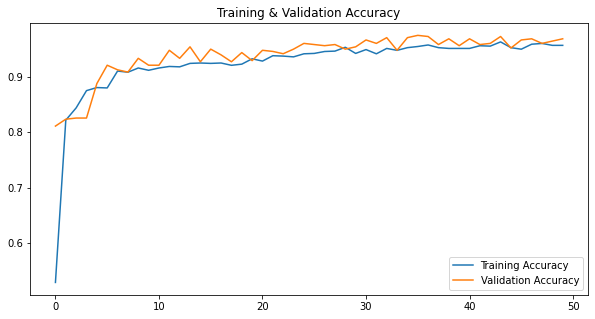

In [37]:
plt.figure(figsize=(10,5))
plt.subplot(1,1,1)

plt.plot(range(EPOCHS),accu,label="Training Accuracy")
plt.plot(range(EPOCHS),val_accu,label="Validation Accuracy")

plt.legend(loc='lower right')
plt.title('Training & Validation Accuracy')

Text(0.5, 1.0, 'Training & Validation Loss')

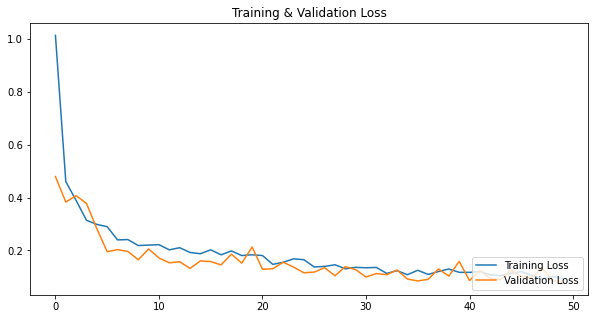

In [38]:
plt.figure(figsize=(10,5))
plt.subplot(1,1,1)

plt.plot(range(EPOCHS),loss,label="Training Loss")
plt.plot(range(EPOCHS),val_loss,label="Validation Loss")

plt.legend(loc='lower right')
plt.title('Training & Validation Loss')

In [47]:
# cap = cv2.VideoCapture(1)  # 0 for webcam

[ WARN:0] global /tmp/pip-req-build-jpmv6t9_/opencv/modules/videoio/src/cap_v4l.cpp (890) open VIDEOIO(V4L2:/dev/video1): can't open camera by index


In [ ]:
# while True:
#     ret, frame = cap.read()
#     cv2.imshow('windows',frame)
    
#     if cv2.waitKey(1) & 0xFF == ord('x'):
#         break
        
# destroyAllWindows(x)